# Analyse des Composantes Principales pour la gestion de portefeuilles d'actions

## Importation des packages

In [11]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import data
import seaborn as sns
import sklearn as sk
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)
np.random.seed(167)

## Vérification des versions

In [12]:
print('Python            version {}'.format(sys.version))
print('Numpy             version {}'.format(np.__version__))
print('Pandas            version {}'.format(pd.__version__))
print('Seabron           version {}'.format(sns.__version__))
print('Sklearn           version {}'.format(sk.__version__))
print('Pandas DataReader version {}'.format(pdr.__version__))

Python            version 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Numpy             version 1.20.3
Pandas            version 1.3.2
Seabron           version 0.11.2
Sklearn           version 1.0.1
Pandas DataReader version 0.10.0


## Récupération des données 

On se focalise sur les 100 entreprises avec la plus grande capitalisation boursière

In [54]:
# Chargement du fichier comportement les capitalisations boursières
market_cap = pd.read_csv("data/market_cap.csv", index_col=0)
market_cap

,marketCap
A,48856465408
AA,9126754304
AAC,1227499904
AACG,67463472
AACI,202746000
...,...
ZWRK,280600000
ZY,970184512
ZYME,873998144
ZYNE,169543664


In [140]:
top100_market_cap = market_cap.marketCap.nlargest(100).index
top100_market_cap

Index(['MSFT', 'AAPL', 'GOOGL', 'GOOG', 'AMZN', 'TSLA', 'FB', 'GE', 'TSM',
       'JPM', 'V', 'BABA', 'UNH', 'JNJ', 'HD', 'BAC', 'WMT', 'PG', 'MA',
       'ASML', 'ADBE', 'NFLX', 'DIS', 'CRM', 'XOM', 'PFE', 'NKE', 'ORCL',
       'NVO', 'TM', 'TMO', 'PYPL', 'LLY', 'CMCSA', 'KO', 'CSCO', 'ACN', 'ABT',
       'COST', 'AVGO', 'PEP', 'CVX', 'DHR', 'VZ', 'MRK', 'WFC', 'SHOP', 'ABBV',
       'INTC', 'QCOM', 'MCD', 'NVDA', 'UPS', 'MS', 'NVS', 'AMD', 'T', 'TXN',
       'LIN', 'INTU', 'LOW', 'SE', 'NEE', 'SAP', 'UNP', 'MDT', 'TBB', 'SONY',
       'HON', 'SCHW', 'AZN', 'RY', 'TMUS', 'PM', 'AXP', 'BLK', 'AMAT', 'C',
       'PTR', 'UL', 'GS', 'TD', 'NOW', 'RTX', 'BHP', 'TTE', 'BA', 'BMY', 'JD',
       'SBUX', 'ABNB', 'TGT', 'CHTR', 'HDB', 'BBL', 'SNY', 'EL', 'CVS', 'DEO',
       'HSBC'],
      dtype='object')

In [141]:
# top100_market_cap=['AAPL',
# 'AMZN',
# 'BA',
# 'BAC',
# 'CSCO',
# 'CVX',
# 'GOOGL',
# 'HD',
# 'INTC',
# 'JNJ',
# 'JPM',
# 'KO',
# 'MA',
# 'MSFT',
# 'PFE',
# 'PG',
# 'T',
# 'UNH',
# 'V',
# 'VZ',
# 'WFC',
# 'WMT',
# 'XOM']

In [151]:
# On considère les données à partir de 2010 jusqu'à 2019
start_date = '2010-01-05'
end_date = '2019-12-31'

# On charge les cours d'actions à partir de Yahoo Finance grace au module Pandas_DataReader
stocks = data.DataReader(top100_market_cap, 'yahoo', start_date, end_date)[["Adj Close"]].pct_change()
stocks.columns = [k[1] for k in stocks.columns.values]
stocks

C:\Users\m.hayne\.conda\envs\du_ml_vers_la_fq\lib\site-packages\pandas_datareader\base.py:272: SymbolWarning: Failed to read symbol: 'NKE', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
C:\Users\m.hayne\.conda\envs\du_ml_vers_la_fq\lib\site-packages\pandas_datareader\base.py:272: SymbolWarning: Failed to read symbol: 'ABNB', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


,MSFT,AAPL,GOOGL,GOOG,AMZN,TSLA,FB,GE,TSM,JPM,V,BABA,UNH,JNJ,HD,BAC,WMT,PG,MA,ASML,ADBE,NFLX,DIS,CRM,XOM,PFE,ORCL,NVO,TM,TMO,PYPL,LLY,CMCSA,KO,CSCO,ACN,ABT,COST,AVGO,PEP,CVX,DHR,VZ,MRK,WFC,SHOP,ABBV,INTC,QCOM,MCD,NVDA,UPS,MS,NVS,AMD,T,TXN,LIN,INTU,LOW,SE,NEE,SAP,UNP,MDT,TBB,SONY,HON,SCHW,AZN,RY,TMUS,PM,AXP,BLK,AMAT,C,PTR,UL,GS,TD,NOW,RTX,BHP,TTE,BA,BMY,JD,SBUX,TGT,CHTR,HDB,BBL,SNY,EL,CVS,DEO,HSBC,NKE,ABNB
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,-0.006137,-0.015906,-0.025209,-0.025209,-0.018116,NaN,NaN,-0.005151,-0.003469,0.005495,-0.013428,NaN,0.009847,0.008134,-0.003463,0.011728,-0.002235,-0.004743,-0.001446,0.009161,-0.002122,0.035139,-0.005314,-0.001745,0.008643,-0.003216,-0.014504,0.011750,0.012773,0.009442,NaN,0.007389,-0.007168,-0.000355,-0.006510,0.010631,0.005553,0.013000,0.007895,-0.010003,0.000126,0.001865,-0.028754,0.013456,0.001425,NaN,NaN,-0.003354,-0.009777,-0.013643,0.006396,-0.007378,0.012796,-0.003615,-0.014418,-0.014632,-0.007347,0.008871,-0.013956,0.002618,NaN,0.009862,0.023281,0.001508,0.016482,NaN,-0.001004,0.000000,-0.018255,-0.007966,-0.001117,-0.067585,0.000000,0.016164,-0.020617,-0.002114,0.031161,0.020601,-0.005411,-0.010673,-0.003512,NaN,-0.005243,0.016461,-0.000303,0.030334,-0.000397,NaN,-0.007206,0.019085,0.000000,0.004477,0.013910,-0.000496,0.003103,-0.008828,-0.002493,0.001181,NaN,NaN
2010-01-07,-0.010400,-0.001849,-0.023280,-0.023280,-0.017013,NaN,NaN,0.051780,-0.033072,0.019809,0.009306,NaN,0.038377,-0.007137,0.011814,0.032947,0.000560,-0.005423,-0.006535,-0.027801,-0.019405,-0.017254,0.000314,-0.004437,-0.003142,-0.003763,-0.003271,-0.008558,-0.012376,0.000000,NaN,-0.005078,0.021059,-0.002486,0.004505,-0.000935,0.008284,-0.004833,-0.006266,-0.006356,-0.003767,0.008244,-0.005952,0.001593,0.036286,NaN,NaN,-0.009615,0.028992,0.007323,-0.019597,-0.007606,0.014484,-0.008784,-0.010449,-0.011227,0.003117,0.002601,-0.003292,0.028721,NaN,-0.002817,0.026299,-0.008886,0.009266,NaN,-0.001675,0.019293,-0.003615,0.010851,-0.002983,0.009396,0.012469,0.016219,0.010994,-0.010594,0.002747,-0.008552,-0.007040,0.019569,-0.013137,NaN,0.004274,-0.008777,-0.002272,0.040482,0.000793,NaN,-0.002562,0.012283,0.000000,0.015969,-0.006196,-0.005462,0.012577,0.036855,0.005881,-0.003202,NaN,NaN
2010-01-08,0.006897,0.006648,0.013331,0.013331,0.027077,NaN,NaN,0.021539,-0.000900,-0.002456,0.002766,NaN,-0.009391,0.003438,-0.004808,-0.008860,-0.005037,-0.001322,0.000355,-0.023927,-0.005422,0.017176,0.001571,0.001486,-0.004012,0.008095,0.012306,0.011868,0.023511,0.016836,NaN,-0.007655,-0.002946,-0.018508,0.005299,-0.003978,0.005112,-0.007202,0.007357,-0.003280,0.001765,0.013981,0.000630,-0.000530,-0.009268,NaN,NaN,0.011165,0.010004,-0.000969,0.002161,0.048076,-0.020352,0.008091,-0.004224,-0.007327,0.022912,0.006546,0.026420,-0.002116,NaN,-0.008663,0.007525,0.033885,0.005246,NaN,0.020470,0.022082,-0.006740,0.004294,0.002992,-0.055851,-0.005451,-0.000715,0.007039,0.038544,-0.016439,0.014142,0.004834,-0.018911,0.003085,NaN,0.001986,0.013719,0.006074,-0.009646,-0.016640,NaN,-0.003424,-0.003978,-0.042857,0.002998,0.018257,0.003245,0.004073,0.007109,-0.000731,-0.002198,NaN,NaN
2010-01-11,-0.012720,-0.008822,-0.001512,-0.001512,-0.024041,NaN,NaN,0.009639,-0.005406,-0.003357,-0.002873,NaN,0.006728,0.000156,-0.028296,0.008939,0.016501,-0.003971,-0.016458,-0.021226,-0.013083,-0.001313,-0.016311,-0.006743,0.011220,0.008030,0.000405,0.031683,0.005130,0.011856,NaN,0.013714,-0.006501,0.020308,-0.002839,-0.000940,0.005087,0.001181,0.006260,-0.001152,0.017743,0.011316,

In [152]:
# stocks = stocks.drop(columns=["TSLA", "FB", "BABA", "NFLX", "GOOG"])

## Préparation des données

In [153]:
stocks = stocks.dropna(thresh=int(stocks.shape[0] * .95), axis=1)
stocks = stocks.dropna(thresh=int(stocks.shape[1] * .95))
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2514 entries, 2010-01-06 to 2019-12-31
Data columns (total 89 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MSFT    2514 non-null   float64
 1   AAPL    2514 non-null   float64
 2   GOOGL   2514 non-null   float64
 3   GOOG    2514 non-null   float64
 4   AMZN    2514 non-null   float64
 5   TSLA    2393 non-null   float64
 6   GE      2514 non-null   float64
 7   TSM     2514 non-null   float64
 8   JPM     2514 non-null   float64
 9   V       2514 non-null   float64
 10  UNH     2514 non-null   float64
 11  JNJ     2514 non-null   float64
 12  HD      2514 non-null   float64
 13  BAC     2514 non-null   float64
 14  WMT     2514 non-null   float64
 15  PG      2514 non-null   float64
 16  MA      2514 non-null   float64
 17  ASML    2514 non-null   float64
 18  ADBE    2514 non-null   float64
 19  NFLX    2514 non-null   float64
 20  DIS     2514 non-null   float64
 21  CRM     2514 non-nu

## Analyse des covariances

In [154]:
cov = stocks.cov()

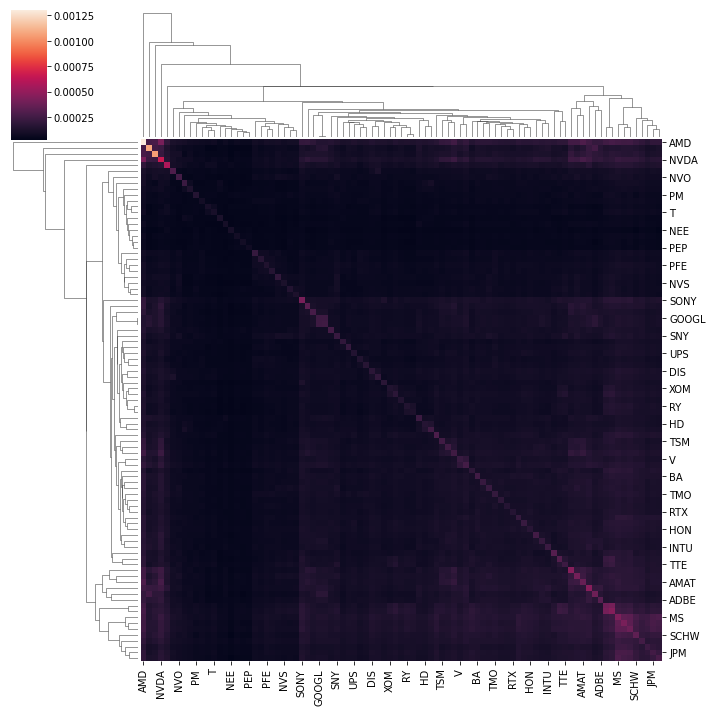

In [155]:
sns.clustermap(cov);

## PCA

In [156]:
pca = PCA()
pca.fit(cov)
pd.Series(pca.explained_variance_ratio_).to_frame('Explained Variance').head(6).style.format('{:,.2%}'.format)

,Explained Variance
0,56.95%
1,10.63%
2,6.89%
3,5.31%
4,3.38%
5,2.56%


In [157]:
top4 = pd.DataFrame(pca.components_[:6], columns=cov.columns)
eigen_portfolios = top4.div(top4.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range(1, 7)]

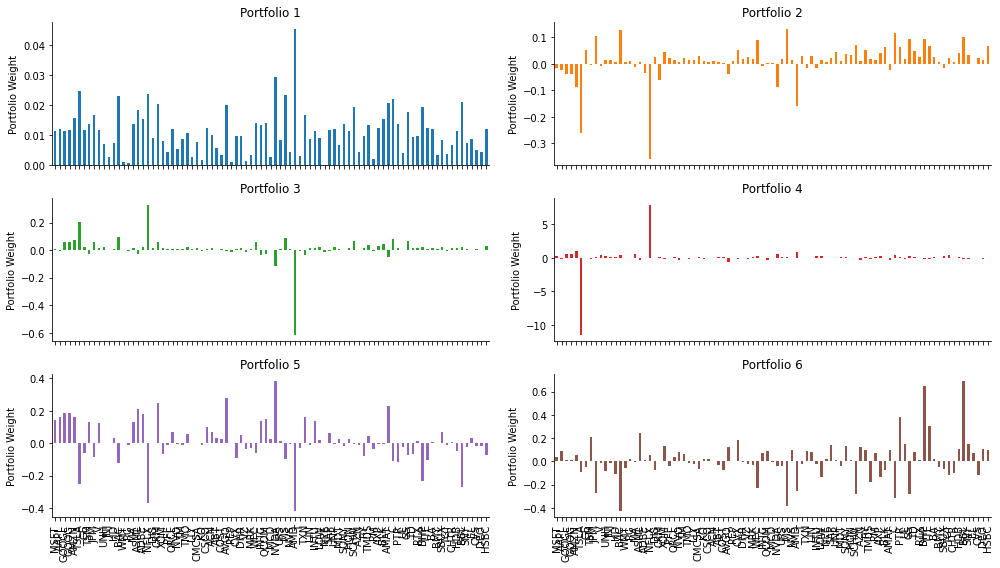

In [158]:
axes = eigen_portfolios.T.plot.bar(subplots=True,
                                   layout=(3, 2),
                                   figsize=(14, 8),
                                   legend=False)
for ax in axes.flatten():
    ax.set_ylabel('Portfolio Weight')
    ax.set_xlabel('')
sns.despine()
plt.tight_layout()

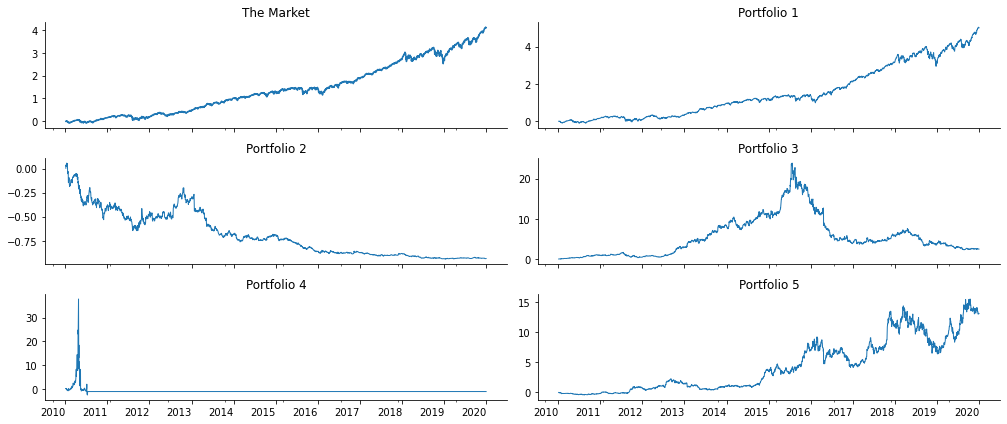

In [159]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 6), sharex=True)
axes = axes.flatten()
stocks.mean(1).add(1).cumprod().sub(1).plot(title='The Market', ax=axes[0])
for i in range(5):
    rc = stocks.mul(eigen_portfolios.iloc[i]).sum(1).add(1).cumprod().sub(1)
    rc.plot(title=f'Portfolio {i+1}', ax=axes[i+1], lw=1, rot=0)

for i in range(6):
    axes[i].set_xlabel('')
sns.despine()
fig.tight_layout()